In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as tt
import torch.utils as utils
from random import sample
import itertools
from torch.utils.data import Dataset, DataLoader
from itertools import chain, combinations
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
from numba import jit, cuda

In [2]:
train_data = torchvision.datasets.MNIST('./data',download=True)
test_data = torchvision.datasets.MNIST('data',train=False)
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
dev_id = torch.cuda.current_device()
print(dev_id, ' , name = ', torch.cuda.get_device_name(dev_id) )
print('memory allocated = ', torch.cuda.memory_allocated(dev_id))
print('memory reserved = ', torch.cuda.memory_reserved(dev_id))


0  , name =  NVIDIA GeForce RTX 4070 Laptop GPU
memory allocated =  0
memory reserved =  0


Text(0.5, 1.0, 'Label of Image:0')

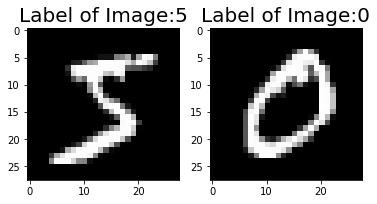

In [5]:
plt.subplot(1,2,1)
image, label = train_data[0]
plt.imshow(image, cmap='gray')
plt.title("Label of Image:{}".format(label),fontsize=20)
plt.subplot(1,2,2)
image, label = train_data[1]
plt.imshow(image, cmap='gray')
plt.title("Label of Image:{}".format(label),fontsize=20)

In [6]:
train_data = torchvision.datasets.MNIST('data',train=True,transform=tt.ToTensor())
test_data = torchvision.datasets.MNIST('data',train=False,transform=tt.ToTensor()) 

In [7]:
x,y = (train_data.data/255).to(device), (train_data.targets).to(device)
xt, yt = torch.clone(x), torch.clone(y)

norm = [0.1,0.5,0,0.1,0.5]
prob = [0,0,1/3,1/3,1/3] #it means 30% will be not correct

for i in range(5):
    k = torch.clone(xt[i*10000:(i+1)*10000])
    xt[i*10000:(i+1)*10000] = k+torch.tensor(np.random.normal(0,norm[i],k.size())).to(device)
    k = torch.clone(yt[i*10000:(i+1)*10000])
    replacements = torch.randint(0,10,k.size()).to(device)
    probs = torch.tensor(np.random.binomial(1.0,prob[i], k.size())).to(device)
    yt[i*10000:(i+1)*10000] = k *(1-probs) + replacements * probs

In [8]:
train_data = torch.utils.data.TensorDataset(torch.cat((x,xt)), torch.cat((y,yt)))
test_data = torch.utils.data.TensorDataset((test_data.data/255).to(device), test_data.targets.to(device))

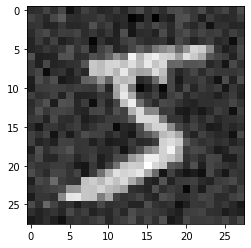

In [9]:
plt.imshow(train_data[60000][0].cpu(), cmap='gray')
plt.show()

In [10]:
input_size = 28*28  #Size of image
num_classes = 10  #the image number are in range 0-10
num_epochs = 5 #one cycle through the full train data
batch_size = 1000 #sample size consider before updating the model’s weights
learning_rate = 0.01  #step size to update parameter

In [11]:
train_dataLoader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
test_dataLoader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)

In [12]:
class LogisticRegression(nn.Module):
    def __init__(self,input_size,num_classes):
        super(LogisticRegression,self).__init__()
        self.linear = nn.Linear(input_size,num_classes)
    
    def forward(self,feature):
        output = self.linear(feature)
        return output

In [13]:
model = LogisticRegression(input_size,num_classes).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [14]:
def train(model, data, epochs):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,shuffle=True)
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    for epoch in range(epochs):
        for images,labels in train_loader:
            images = torch.autograd.Variable(images.view(-1,input_size))
            labels = torch.autograd.Variable(labels).to(device)
            
            optimizer.zero_grad()
            output = model(images)
            compute_loss = loss(output,labels)
            compute_loss.backward()
            optimizer.step()
        
def test(model):
    accurate = 0
    total = 0
    for images,labels in test_dataLoader:
        images = torch.autograd.Variable(images.view(-1,input_size))
        output = model(images)
        _,predicted = torch.max(output.data, 1)
        # total labels
        total+= labels.size(0)

        # Total correct predictions
        accurate+= (predicted == labels).sum()
        accuracy_score = 100 * accurate/total
    return accuracy_score

In [15]:
# Drawing indices from the dataset

ind1 = [i for i in range(len(train_data)//2) if train_data[i][1] in [0,1,2]]
ind2 = [i for i in range(len(train_data)//2) if train_data[i][1] in [0,1,2,3,4]]
ind3 = sample(range(len(train_data)), 5000)
ind4 = sample(range(len(train_data)), 10000)
ind5 = [i for i in range(60000, 70000)]
ind6 = [i for i in range(70000, 80000)]
ind7 = [i for i in range(80000, 90000)]
ind8 = [i for i in range(90000, 100000)]
ind9 = [i for i in range(100000, 110000)]

In [16]:
index_list = [ind1, ind2, ind3, ind4, ind5, ind6, ind7, ind8, ind9]

In [17]:
class dataset(Dataset):
    def __init__(self,indices, transform=None):
        self.X = torch.stack([train_data[i][0] for i in indices])
        self.Y = torch.tensor([train_data[i][1] for i in indices])
        self.transform = transform

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        self.x = self.X[idx]
        self.y = self.Y[idx]
        return self.x, self.y

In [18]:
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [19]:
@jit(target_backend='cuda')                         
def data_shap(idx, index_list, data):
    val = []
    idxs = list(powerset(range(len(index_list))))
    w_idx = [x for x in idxs if idx in x]
    wo_idx = [x for x in idxs if idx not in x]
    print(len(w_idx))
    for i in range(len(w_idx)):
        print(i, end=',')
        if i != 0:
            indices1 = [index_list[j] for j in w_idx[i]]
            indices1 = list(set(sum(indices1,[])))
            
            indices2 = [index_list[j] for j in wo_idx[i]]
            indices2 = list(set(sum(indices2,[])))
            
            model1 = LogisticRegression(input_size,num_classes).to(device)
            model2 = LogisticRegression(input_size,num_classes).to(device)
            
            data1 = dataset(indices1)
            data2 = dataset(indices2)
            
            train(model1, data1, epochs = 5)
            train(model2, data2, epochs = 5)
            
            p1 = test(model1)
            p2 = test(model2)
            val.append((p1-p2).cpu())
            #print(p1)
            #print(p2)
            
        if i == 0:
            indices1 = [index_list[j] for j in w_idx[i]]
            indices1 = list(set(sum(indices1,[])))

            indices2 = [index_list[j] for j in wo_idx[i]]
            indices2 = list(set(sum(indices2,[])))
            
            model1 = LogisticRegression(input_size,num_classes).to(device)
            model2 = LogisticRegression(input_size,num_classes).to(device)
            
            data1 = dataset(indices1)
            
            train(model1, data1, epochs = 5)
            
            p1 = test(model1)
            p2 = test(model2)
            val.append((p1-p2).cpu())
            #print(p1)
            #print(p2)
            
    return np.mean(val)

In [20]:
zero = data_shap(0, index_list, train_data)
print(zero)

256
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,-7.165703


In [21]:
one = data_shap(1, index_list, train_data)
print(one)

256
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,-9.276327


In [22]:
two = data_shap(2, index_list, train_data)
print(two)

256
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,3.404101


In [23]:
three = data_shap(3, index_list, train_data)
print(three)

256
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,6.6713667


In [24]:
four = data_shap(4, index_list, train_data)
print(four)
five = data_shap(5, index_list, train_data)
print(five)
six = data_shap(6, index_list, train_data)
print(six)
seven = data_shap(7, index_list, train_data)
print(seven)
eight = data_shap(8, index_list, train_data)
print(eight)

256
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,7.6742573
256
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,

In [27]:
shap_values = [zero, one, two, three, four, five, six, seven, eight]

[-7.165703, -9.276327, 3.404101, 6.6713667, 7.6742573, 7.77289, 5.747187, 5.6400776, 5.645547]


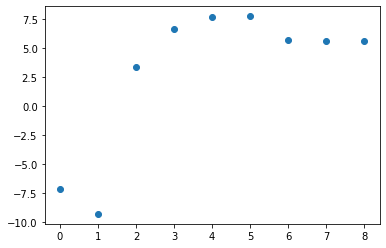

In [28]:
print(shap_values)
plt.plot(shap_values,'o')
plt.show()

[-7.187499, 7.6812496, 6.6100006, 11.39875]


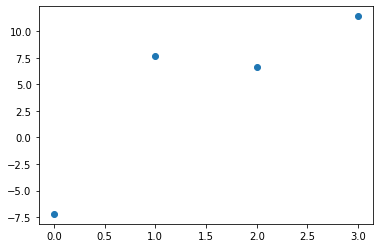

In [27]:
print(shap_values)
plt.plot(shap_values,'o')
plt.show()